In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

In [112]:
df = pd.read_csv('MBB Historical Data.csv', header=0, parse_dates=[0], index_col=0)
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df = df[["Price", "High"]]
print(df.head())


     Price     High
0  10696.2  10696.2
1  10595.5  10817.0
2  10615.6  10696.2
3  10535.0  10655.9
4  11058.8  11058.8


In [113]:
#Check for Stationarity
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [114]:
adf_test(df['Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.371033
p-value                    0.596082
# lags used                0.000000
# observations          1491.000000
critical value (1%)       -3.434743
critical value (5%)       -2.863480
critical value (10%)      -2.567803
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [115]:
adf_test(df['High'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.309214
p-value                    0.624946
# lags used                1.000000
# observations          1490.000000
critical value (1%)       -3.434746
critical value (5%)       -2.863482
critical value (10%)      -2.567804
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [116]:
# Neither variable is stationary, so we’ll take a first-order difference of the entire DataFrame and re-run the augmented Dickey-Fuller test.
df_difference = df.diff()
adf_test(df_difference['Price'])
adf_test(df_difference['High'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -38.810276
p-value                    0.000000
# lags used                0.000000
# observations          1490.000000
critical value (1%)       -3.434746
critical value (5%)       -2.863482
critical value (10%)      -2.567804
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: 
ADF test statistic       -35.407996
p-value                    0.000000
# lags used                0.000000
# observations          1490.000000
critical value (1%)       -3.434746
critical value (5%)       -2.863482
critical value (10%)      -2.567804
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [134]:
# Split the data into training, testing
df_difference = df_difference.dropna() # Drop missing values
df_difference = df_difference.reset_index(drop=True) # Reset the index

train_size = int(0.9 * len(df_difference))
test_size = len(df_difference) - train_size

train = df_difference[:train_size]
test = df_difference[train_size:]


In [135]:
#Grid Search for Order P
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  21.98446582938045
BIC:  22.007751313975724

Order = 2
AIC:  21.824062116450943
BIC:  21.862894665709277

Order = 3
AIC:  21.745063832502325
BIC:  21.799462216186654

Order = 4
AIC:  21.693782539198732
BIC:  21.763765564170935

Order = 5
AIC:  21.694121979164418
BIC:  21.779708489486367

Order = 6
AIC:  21.68951132887712
BIC:  21.790720205912095

Order = 7
AIC:  21.685859249745103
BIC:  21.802709412259546

Order = 8
AIC:  21.67403179450651
BIC:  21.806542198772135

Order = 9
AIC:  21.678231601174197
BIC:  21.826421241070452

Order = 10
AIC:  21.66159156816891
BIC:  21.82547947528581

Order = 11
AIC:  21.664141743798414
BIC:  21.843746987539713

Order = 12
AIC:  21.664845962820543
BIC:  21.86018765050727



In [136]:
#As you keep on increasing the value of the P model becomes more complex. AIC penalizes the complex model.
#AIC begins to drop as we fit the more complex model but, after a certain amount of time AIC begins to increase again. 
#It’s because AIC is punishing these models for being too complex.
#VAR(11) returns the lowest score and after that again AIC starts increasing, hence we will build the VAR model of order ...

result = model.fit(8)
result.summary()



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Dec, 2023
Time:                     23:12:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.8065
Nobs:                     1333.00    HQIC:                   21.7237
Log likelihood:          -18194.6    FPE:                2.58770e+09
AIC:                      21.6740    Det(Omega_mle):     2.52294e+09
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            6.071775         9.825025            0.618           0.537
L1.Price        -0.088777         0.045919           -1.933           0.053
L1.High          0.161877         0.070007            2.312           0.021
L2.P

In [137]:
# Forecast
lag_order = result.k_ar
forecast = result.forecast(train.values[-lag_order:], steps=test_size)

# Convert the forecast array to a DataFrame
forecast_df = pd.DataFrame(forecast, columns=df.columns)

# Invert the differencing to obtain the forecast in the original scale
forecast_original_scale = pd.concat([pd.DataFrame(train.iloc[-1:].values, columns=df.columns), forecast_df]).cumsum().iloc[1:]

# Convert the forecasted differences back to the original scale
forecast_original_scale = forecast_original_scale + df.iloc[train_size - 1:].reset_index(drop=True)

#drop na value
forecast_original_scale = forecast_original_scale.dropna()
forecast_original_scale


,Price,High
0,18783.877729,18920.264679
1,18681.820171,19041.489874
2,18573.099071,18902.214344
3,18419.916793,18673.977091
4,18431.844058,18585.853948
...,...,...
145,18829.597996,19222.391099
146,18835.387016,19078.129070
147,18841.176037,19083.867042
148,18796.965057,19039.605014


In [138]:
# Extract the actual test data for comparison
actual_values = df[['Price', 'High']].iloc[train_size+1:].reset_index(drop=True)


from sklearn.metrics import mean_squared_error, mean_absolute_error
# Đánh giá độ chính xác test bằng RMSE, MAE , MAPE
# Calculate RMSE
rmse_price = np.sqrt(np.mean((forecast_original_scale['Price'] - actual_values['Price'])**2))
rmse_high = np.sqrt(np.mean((forecast_original_scale['High'] - actual_values['High'])**2))

# Calculate MAPE
mape_price = np.mean(np.abs((actual_values['Price'] - forecast_original_scale['Price']) / actual_values['Price'])) * 100
mape_high = np.mean(np.abs((actual_values['High'] - forecast_original_scale['High']) / actual_values['High'])) * 100

# Calculate MAE
mae_price = mean_absolute_error(actual_values['Price'], forecast_original_scale['Price'])
mae_high = mean_absolute_error(actual_values['High'], forecast_original_scale['High'])

# Print the results
print("RMSE (Price):", rmse_price)
print("RMSE (High):", rmse_high)
print("MAPE (Price):", mape_price, "%")
print("MAPE (High):", mape_high, "%")
print("MAE (Price):", mae_price)
print("MAE (High):", mae_high)


RMSE (Price): 644.1740937334921
RMSE (High): 700.2699819877485
MAPE (Price): 2.6817114368299655 %
MAPE (High): 3.039253660447398 %
MAE (Price): 494.6131952967777
MAE (High): 565.018640084092


In [140]:
# Forecast the next 30 days
forecast_steps = 30
forecast_30 = result.forecast(df_difference.values[-lag_order:], steps=forecast_steps)

# Convert the forecast array to a DataFrame
forecast_30_df = pd.DataFrame(forecast_30, columns=df_difference.columns)

# Invert the differencing to get the forecast in the original scale
# Adding the last observation from the original dataset (not the differenced one)
last_original_observation = df.iloc[-1]
forecast_original_30 = forecast_30_df.cumsum() + last_original_observation

# Creating an index for the next 30 days
last_index = df.index[-1]
next_30_indexes = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
forecast_original_30.set_index(next_30_indexes, inplace=True)

forecast_original_30

,Price,High
1492,18145.543198,18231.848176
1493,18128.766345,18221.857022
1494,18163.283941,18236.557313
1495,18181.273846,18257.366801
1496,18186.688983,18269.610826
1497,18189.513475,18272.847485
1498,18193.673232,18268.214043
1499,18209.240567,18275.330525
1500,18205.657352,18284.662511
1501,18209.213341,18287.616627


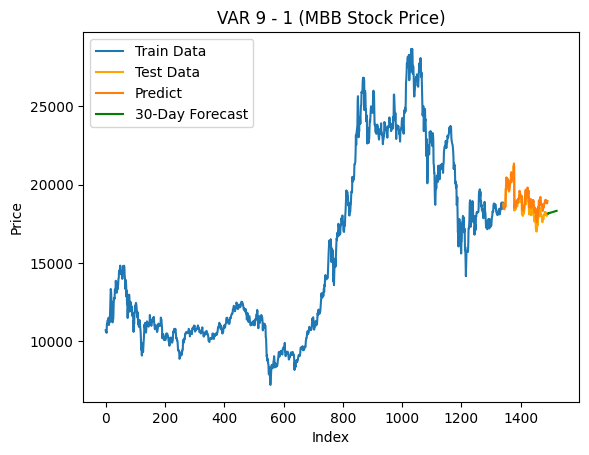

In [142]:
# Plotting the forecast
#plt.figure(figsize=(15, 6))
# Train data
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train Data')
# Test data
plt.plot(df.index[train_size:train_size + test_size], df['Price'][train_size:train_size + test_size], label='Test Data', color='orange')
#predict
plt.plot(df.index[train_size:train_size + test_size], forecast_original_scale['Price'], label='Predict')

plt.plot(forecast_original_30.index, forecast_original_30['Price'], label='30-Day Forecast', color='green')
plt.title('VAR 9 - 1 (MBB Stock Price)')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()